In [1]:
hip_lp_ckpt = '/niddk-data-central/leo_workspace/MoCA_result/LP/ckpt/Hip_20epochLP_blr_0.01_bs_256_input_size_[3, 100]/2025-04-27_02-37/checkpoint-best.pth'


In [2]:
import models_vit
import torch

hip_lp_model = models_vit.__dict__['vit_base_patch16'](
            img_size=[3,100], patch_size=[1, int(5)], 
            num_classes=2, in_chans=1, 
            global_pool=False)
hip_lp_model.head = torch.nn.Sequential(torch.nn.BatchNorm1d(768, affine=False, eps=1e-6), hip_lp_model.head)


/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hip-LP CM

In [3]:
hip_lp_checkpoint = torch.load(hip_lp_ckpt, map_location='cpu')['model']
if any(k.startswith("module.") for k in hip_lp_checkpoint.keys()):
    hip_lp_checkpoint = {k.replace("module.", ""): v for k, v in hip_lp_checkpoint.items()}
    
hip_lp_model.load_state_dict(hip_lp_checkpoint, strict=True)


<All keys matched successfully>

In [4]:
# import torch
# from util.datasets import iWatch_HDf5,collate_fn

# def get_loader(data_path,subset=None):
#     if subset is not None:
#         dataset_val = iWatch_HDf5(data_path, set_type='val', transform=None,subset=subset)
#         sampler_val = torch.utils.data.SequentialSampler(dataset_val)
#     else:
#         dataset_val = iWatch_HDf5(data_path, set_type='val', transform=None)
#         sampler_val = torch.utils.data.SequentialSampler(dataset_val)

#     data_loader_val = torch.utils.data.DataLoader(
#             dataset_val,
#             sampler = sampler_val,
#             batch_size=1024,
#             num_workers=2,
#             pin_memory=True,
#             drop_last=False,
#             persistent_workers=True,
#             collate_fn = collate_fn)

#     return data_loader_val

# hip_loader = get_loader('/niddk-data-central/iWatch/pre_processed_seg/H')

import sys
from main_attnprobe import AttentionProbeModel
sys.path.append('/DeepPostures_MAE/MSSE-2021-pt')
from commons import get_dataloaders
import random
import pickle

def get_iterloader(data_path):
    with open("/niddk-data-central/iWatch/support_files/iwatch_split_dict.pkl", "rb") as f:
        split_data = pickle.load(f)

        train_subjects = split_data["train"]
        valid_subjects = ['i0084A', 'i0209A'] #split_data["val"][:2]
        print(valid_subjects)
        

        #random.shuffle(train_subjects)
        random.shuffle(valid_subjects)

        _, val_loader, _ = get_dataloaders(
        pre_processed_dir=data_path,
        bi_lstm_win_size=42,
        batch_size=4,
        train_subjects=train_subjects,
        valid_subjects=valid_subjects,
        test_subjects=None,
    )

    return val_loader

hip_loader = get_iterloader('/niddk-data-central/iWatch/pre_processed_pt/H')

['i0084A', 'i0209A']


In [5]:
from itertools import chain
from tqdm import tqdm
import numpy as np
from sklearn.metrics import balanced_accuracy_score

def mae_classification_pass(data_loader, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # ensures dropout etc. is disabled
    print('using', device)

    # Use flat Python lists
    preds_list = []
    targets_list = []

    # no gradient needed
    for batch in tqdm(data_loader):
        images = batch[0].float().to(device, non_blocking=True)
        target = batch[-1].to(device, non_blocking=True)
        
        with torch.no_grad():
            output = model(images)
        pred = torch.argmax(output, dim=1)

        preds_list.extend(pred.cpu().tolist())
        targets_list.extend(target.cpu().tolist())

    balanced_acc = balanced_accuracy_score(targets_list, preds_list)
    return preds_list, targets_list, balanced_acc


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cm(cm_all, title, labels=['Sitting', 'Non-Sitting']):
    fig, ax = plt.subplots(figsize=(6, 5))  # use object-oriented API

    sns.heatmap(
        cm_all,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
        annot_kws={"size": 20},
        cbar=False,
        linewidths=0.2,
        linecolor='white',
        ax=ax
    )
    ax.set_title(title, fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    fig.tight_layout()

    return fig


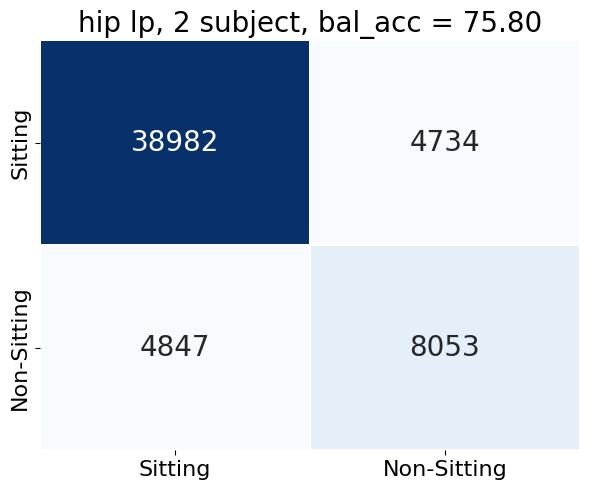

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from engine_finetune_long import evaluate_cm
hip_lp_model = hip_lp_model.to('cuda')
cm_all,accuracy_all = evaluate_cm(hip_loader,hip_lp_model,device='cuda',as_img=True)
trial_classification = f'hip lp, 2 subject, bal_acc = {accuracy_all:.2f}'
#cm_all = confusion_matrix(target_all, pred_all)

cm_plt = plot_cm(cm_all,trial_classification)


In [10]:
# # Add to wandb
import wandb
wandb.login(key='32b6f9d5c415964d38bfbe33c6d5c407f7c19743')
run = wandb.init(project='MoCA-iWatch-LP', id='e7r262yh', resume='allow')
wandb.log({"confusion_matrix": wandb.Image(cm_plt)})
run.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yuc204 (leo085) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_epoch_acc1,86.19093
best_epoch_bal_acc,81.52494
best_epoch_epoch,12
best_epoch_f1,86.14721
epoch,19
loss,0.36652
lr,0.0
perf/bal_acc,79.47639
perf/f1,86.06857
perf/test_acc1,86.49966
perf/test_loss,0.32907


# Wrist LP

In [8]:
import models_vit
wrist_lp_ckpt = '/niddk-data-central/leo_workspace/MoCA_result/LP/ckpt/Wrist_20epochblr_0.01_bs_256_input_size_[3, 100]/2025-04-26_20-00/checkpoint-best.pth'

wrist_lp_model = models_vit.__dict__['vit_base_patch16'](
            img_size=[3,100], patch_size=[1, int(5)], 
            num_classes=2, in_chans=1, 
            global_pool=False)
            
wrist_lp_model.head = torch.nn.Sequential(torch.nn.BatchNorm1d(768, affine=False, eps=1e-6), wrist_lp_model.head)

wrist_lp_checkpoint = torch.load(wrist_lp_ckpt, map_location='cpu')['model']
if any(k.startswith("module.") for k in wrist_lp_checkpoint.keys()):
    wrist_lp_checkpoint = {k.replace("module.", ""): v for k, v in wrist_lp_checkpoint.items()}
wrist_lp_model.load_state_dict(wrist_lp_checkpoint, strict=True)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

using cuda


100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


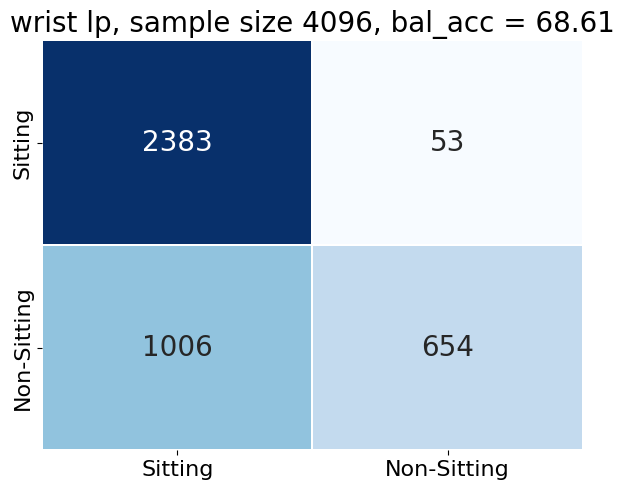

In [11]:
from sklearn.metrics import confusion_matrix
wrist_loader = get_loader('/niddk-data-central/iWatch/pre_processed_seg/W',subset=4096)
wrist_pred_all, wrist_target_all, wrisst_accuracy_all = mae_classification_pass(wrist_loader,wrist_lp_model)
trial_classification = f'wrist lp, sample size 4096, bal_acc = {wrisst_accuracy_all*100:.2f}'
wrist_cm_all = confusion_matrix(wrist_target_all, wrist_pred_all)

wrist_cm_plt = plot_cm(wrist_cm_all,trial_classification)

In [13]:
import wandb
wandb.login(key='32b6f9d5c415964d38bfbe33c6d5c407f7c19743')
run = wandb.init(project='MoCA-iWatch-LP', id='j4gvl2vd', resume='allow')
wandb.log({"confusion_matrix": wandb.Image(wrist_cm_plt)})
run.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yuc204 (leo085) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_epoch_acc1,78.25779
best_epoch_bal_acc,72.58645
best_epoch_epoch,10
best_epoch_f1,78.36795
epoch,19
loss,0.42465
lr,0.0
perf/bal_acc,69.33698
perf/f1,79.02576
perf/test_acc1,80.53066
perf/test_loss,0.43943


# Attention Probe

In [ ]:
import sys
from main_attnprobe import AttentionProbeModel
sys.path.append('/DeepPostures_MAE/MSSE-2021-pt')
from commons import get_dataloaders
import random
import pickle

def get_iterloader(data_path):
    with open("/niddk-data-central/iWatch/support_files/iwatch_split_dict.pkl", "rb") as f:
        split_data = pickle.load(f)

        train_subjects = split_data["train"]
        valid_subjects = ['i0084A', 'i0209A'] #split_data["val"][:2]
        print(valid_subjects)
        

        #random.shuffle(train_subjects)
        random.shuffle(valid_subjects)

        _, val_loader, _ = get_dataloaders(
        pre_processed_dir=data_path,
        bi_lstm_win_size=42,
        batch_size=4,
        train_subjects=train_subjects,
        valid_subjects=valid_subjects,
        test_subjects=None,
    )

    return val_loader

hip_loader = get_iterloader('/niddk-data-central/iWatch/pre_processed_pt/H')

In [2]:
import models_vit
def get_model(model_path):
    base_model = models_vit.__dict__['vit_base_patch16'](
            img_size=[3,100], patch_size=[1, 5], 
            num_classes=2, in_chans=1, 
            global_pool=False)

    model = AttentionProbeModel(
        base_model,
        window_size=42,
        num_classes=2,
        hidden_dim=256,
        num_layer=2
    )

    checkpoint = torch.load(model_path, map_location='cpu')['model']
    if any(k.startswith("module.") for k in checkpoint.keys()):
        checkpoint = {k.replace("module.", ""): v for k, v in checkpoint.items()}
    model.load_state_dict(checkpoint, strict=True)
    
    return model

In [16]:
import torch
hip_loader = get_iterloader('/niddk-data-central/iWatch/pre_processed_pt/H')
hip_model_path = '/niddk-data-central/leo_workspace/MoCA_result/LP/ckpt/Hip_20epochLP_blr_0.001_bs_32_input_size_[3, 100]/2025-05-02_20-21/checkpoint-best.pth'

hip_model = get_model(hip_model_path)
hip_model = hip_model.to('cuda')

['i0084A', 'i0209A']


In [4]:
from engine_finetune_long import evaluate_cm

cm,bal_acc = evaluate_cm(hip_loader,hip_model,device='cuda')

100%|██████████| 2/2 [00:45<00:00, 22.80s/it]

* Acc@1 91.14915 bal_acc 86.76874 f1 91.08954 loss 0.243


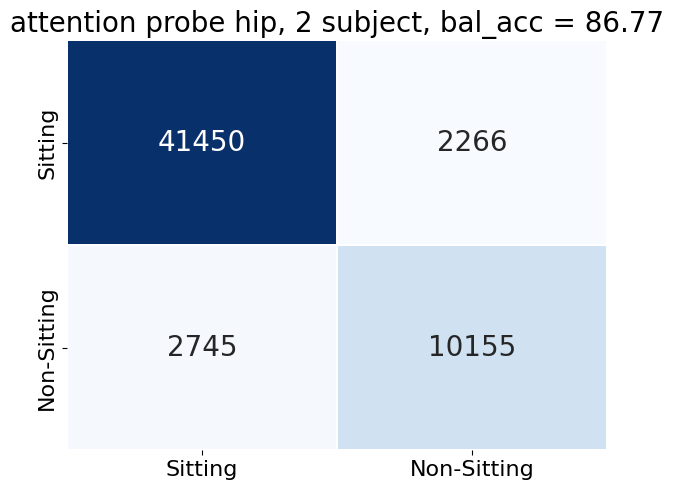

In [13]:
hip_fig = plot_cm(cm,f'attention probe hip, 2 subject, bal_acc = {bal_acc:.2f}')

In [14]:
# # Add to wandb
import wandb
wandb.login(key='32b6f9d5c415964d38bfbe33c6d5c407f7c19743')
run = wandb.init(project='MoCA-iWatch-attention-probe', id='cjc32g3x', resume='allow')
wandb.log({"confusion_matrix": wandb.Image(hip_fig)})
run.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_epoch_acc1,91.33502
best_epoch_bal_acc,89.45468
best_epoch_epoch,15
best_epoch_f1,91.41254
epoch,19
loss,0.63288
lr,1e-05
perf/bal_acc,87.451
perf/f1,91.3953
perf/test_acc1,91.51332
perf/test_loss,0.2316


# Attention Prob Markdown